## MOEA/D_ALFPA


This algorithm is implemented based on <cite data-cite="moead"></cite>. The algorithm is based on [Reference Directions](../misc/reference_directions.ipynb) which need to be provided when initializing the algorithm object.

In [6]:
import math
import numpy as np
from scipy.spatial.distance import cdist

from pymoo.algorithms.so_cuckoo_search import MantegnasAlgorithm
from pymoo.decomposition.pbi import PBI
from pymoo.docs import parse_doc_string
from pymoo.model.algorithm import Algorithm
from pymoo.model.duplicate import DefaultDuplicateElimination
from pymoo.model.initialization import Initialization
from pymoo.model.population import Population
from pymoo.operators.repair.to_bound import set_to_bounds_if_outside
from pymoo.operators.sampling.random_sampling import FloatRandomSampling
from pymoo.util.termination.default import MultiObjectiveDefaultTermination
from pymoo.util.misc import has_feasible
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

class AdaptiveLevyFlight:
    def __init__(self, alpha, beta, do_all=True):
        self.alpha = alpha
        #beta must be in range of [1..2]
        beta = min(beta, 2)
        beta = max(beta, 1)
        self.beta = beta            
        self.cauchy = np.random.default_rng().standard_cauchy
        self.gaussian = np.random.default_rng().standard_normal        
        self.do_all = do_all
        if do_all:
            self.levy1 = MantegnasAlgorithm(1.3) 
            self.levy2 = MantegnasAlgorithm(1.7)
        else:
            self.levy = MantegnasAlgorithm(beta)        

    def _do_all(self, xbest, xi, xl, xu):
        cstep = self.cauchy(len(xi))
        lstep1 = self.levy1.do(len(xi))
        lstep2 = self.levy2.do(len(xi))
        gstep = self.gaussian(len(xi))
        steps = np.array([cstep, lstep1, lstep2, gstep])
        direction = xbest-xi
        scale = xu-xl
        _X = xi + direction*scale*steps
        _X = set_to_bounds_if_outside(_X, xl, xu)
        return Population.new(X=_X)
    
    def _do(self, xbest, xi, xl, xu):
        
        if self.do_all:
            return self._do_all(xbest, xi, xl, xu)
        
        # get random levy values to be used for the step size
        if self.beta == 1:
            levy = self.cauchy(len(xi))
        elif self.beta == 2:
            levy = self.gaussian(len(xi))
        else:
            levy = self.levy.do(len(xi))
        direction = (xbest-xi)
        _x = xi + (xu - xl)*self.alpha * levy * direction
        _x = set_to_bounds_if_outside(_x, xl, xu)

        return Population.new(X=_x[None, :])    
    
    
def calc_harmonic_average_distance(points, neighbors=None):
    dist_mat = []
    K = len(points)
    if neighbors is None:
        #had among themselves        
        dist_mat = cdist(points, points)
        np.fill_diagonal(dist_mat, np.inf)
        K = len(points) - 1
    else:
        dist_mat  = cdist(points, neighbors)
        K = len(neighbors)
        
    dist_mat_inv = 1/dist_mat
    had = K/np.sum(dist_mat_inv, axis=1)
    return had    

class MOEAD_ALFPA(Algorithm):

    def __init__(self,
                 ref_dirs,
                 sampling=FloatRandomSampling(),
                 eliminate_duplicates=DefaultDuplicateElimination(),
                 termination=MultiObjectiveDefaultTermination(),
                 decomposition=PBI(),
                 adaptive=False,
                 archive_size=100,
                 n_neighbors=None,
                 n_replacement=3,                 
                 alpha=0.01,
                 p=0.8,
                 pa=0.8,
                 **kwargs):
        """

        Parameters
        ----------
        display : {display}
        sampling : {sampling}
        survival : {survival}
        eliminate_duplicates: This does not exists in the original paper/book.
            Without this the solutions might get too biased to current global best solution,
            because the global random walk use the global best solution as the reference.

        termination : {termination}

        pop_size : The number of nests (solutions)

        beta : The input parameter of the Mantegna's Algorithm to simulate
            sampling on Levy Distribution

        alfa : alfa is the step size scaling factor and is usually
            0.01, so that the step size will be scaled down to O(L/100) with L is
            the scale (range of bounds) of the problem.

        pa   : The switch probability
        """

        super().__init__(**kwargs)
        
        #prepare operators
        self.adaptive = adaptive
        if not adaptive:
            self.grw = AdaptiveLevyFlight(alpha, 0, do_all=True)
        else:
            cauchy = AdaptiveLevyFlight(alpha, 1, do_all=False)
            levy1 = AdaptiveLevyFlight(alpha, 1.3, do_all=False)
            levy2 = AdaptiveLevyFlight(alpha, 1.7, do_all=False)
            gaussian = AdaptiveLevyFlight(alpha, 2, do_all=False)
            self.mating = [cauchy, levy1, levy2, gaussian]

        self.initialization = Initialization(sampling)        
        self.default_termination = termination
        self.eliminate_duplicates = eliminate_duplicates
        self.decomposition = decomposition
        self.nds = NonDominatedSorting()  
        
        self.archive_size = archive_size
        self.ref_dirs = ref_dirs
        self.pop_size = len(ref_dirs)
        #prepare neighbours list
        #neighbours includes the entry by itself intentionally for the survival method
        self.n_neighbors = n_neighbors
        if n_neighbors is None:
            self.n_neighbors = int(0.1*self.pop_size)
        self.neighbors_list = np.argsort(cdist(self.ref_dirs, self.ref_dirs), axis=1, kind='quicksort')
        self.neighbors_list = self.neighbors_list[:, :self.n_neighbors]
                
        #the scale will be multiplied by problem scale after problem given in setup                
        self.alpha = alpha
        self.p = p
        self.pa = pa
        self.n_replacement = n_replacement          
        
        #parameters for adaptive operators
        self.c = 5
        self.W = int(self.pop_size/2)
        self.used_op = np.full(self.W, -1)
        self.op_rewards = np.full(self.W, 0)
        self.sw_idx = 0
       
        #prepare external archive
        self.ideal_point = []        
        
        
    def _initialize(self):
        pop = self.initialization.do(self.problem,
                                     self.pop_size,
                                     algorithm=self,
                                     eliminate_duplicates=self.eliminate_duplicates)
        self.evaluator.eval(self.problem, pop, algorithm=self)
        self.pop = pop
        self.opt = pop
        F = self.pop.get("F")
        self.ideal_point = np.min(F, axis=0)
        self.nadir_point = np.max(F, axis=0)

    def _set_optimum(self, **kwargs):
        self.opt = self.pop
        
    def _lrw(self, X, xi, xl, xu, n_offsprings):
        #find n_offsprings*2 different solutions (n_offsprings pair) 
        Pair = np.random.permutation(X)[:2*n_offsprings]
        R1, R2 = Pair[:n_offsprings], Pair[n_offsprings:2*n_offsprings]
        r = np.tile(np.random.rand(n_offsprings), (self.problem.n_var, 1)).T
        _X = xi + r*(R1-R2)
        _X = set_to_bounds_if_outside(_X, xl, xu)
        return Population.new(X=_X)
    
    #operator index : 0->Global Random Walk 1->Local Random Walk
    def _calc_op_score(self, FRR, op_freq):
        op_freq_ratio = self.c + np.sqrt(2*np.log(np.sum(op_freq))/op_freq)
        score = FRR + op_freq_ratio
        return score

    def _choose_op(self):
        I_op = [self.used_op == 0, self.used_op == 1]
        op_freq = np.array([len(self.used_op[I_op[0]]), len(self.used_op[I_op[1]])])
        #if there is an unused operator then randomly pick from the two
        if op_freq[0]==0 or op_freq[1]==0:
            return np.random.randint(2)
        reward0 = np.sum(self.op_rewards[I_op[0]])
        reward1 = np.sum(self.op_rewards[I_op[1]])
        tot_rewards = np.sum(self.op_rewards)
        FRR = np.array([reward0, reward1])
        op_score = self._calc_op_score(FRR, op_freq)
        return np.argmin(op_score)
        
    def _next(self):
        xl, xu = self.problem.bounds()
        pop_idx_permutation = np.random.permutation(self.pop_size)
        X = self.pop.get("X")
        F = self.pop.get("F")
        Xopt = self.opt.get("X")
        for idx in pop_idx_permutation:                        
            xi = X[idx]            
            #choose current neighbourhood wether from ref neighbors or from all population
            #N = neighborhood
            if np.random.rand() < self.p:
                N = self.neighbors_list[idx]
            else:
                N = np.arange(self.pop_size)        
            
            #permute the N so that they have fair chance to be updated (because)
            #the number of improvement is limited
            N = np.random.permutation(N)
            
            #choose operator
            
                        
            #evaluate and update ideal value
            self.evaluator.eval(self.problem, off)
            _F = off.get("F")
            _X = off.get("X")
            self.ideal_point = np.min(np.vstack([self.ideal_point, _F]), axis=0)

            # calculate the decomposed values for each neighbor
            rho = self.alpha**self.problem.n_var
            FV = self.decomposition.do(F[N], weights=self.ref_dirs[N, :], ideal_point=self.ideal_point, rho=rho)
            off_FV = self.decomposition.do(_F, weights=self.ref_dirs[N, :], ideal_point=self.ideal_point, rho=rho)
#             print("--------------------------------")
#             print(_F)
#             print(FV, off_FV)
#             print(self.ref_dirs[N, :])
#             #get the best candidate of offspring for each ref_dirs
#             off_FV_idx = np.argmin(off_FV, axis=0)
#             off_FV = np.min(off_FV, axis=0)
            
            #update some of the neighbours, if the new solution is better
            #limited to number of replacement n_replacement
            idx = np.arange(len(N))
            improved = off_FV < FV                        
            idx = idx[improved][:self.n_replacement]
            X[idx] = _X
            F[idx] = _F
        
        #loop ends
        #not "get"ting too many times in the loop because it's costly
        self.pop.set("X", X)
        self.pop.set("F", F)
#         print(self.n_gen)

parse_doc_string(MOEAD_ALFPA.__init__)

12.82529878616333


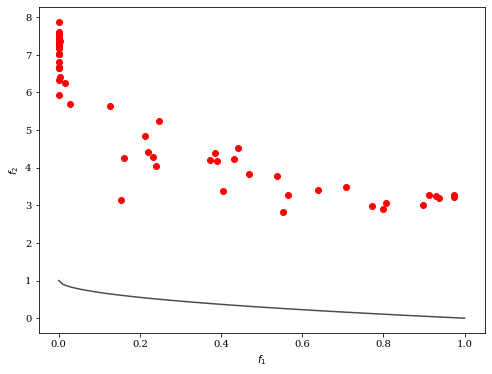

In [21]:
from pymoo.factory import get_problem, get_visualization, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.perp_dist import PerpendicularDistance
from pymoo.decomposition.tchebicheff import Tchebicheff

problem = get_problem("zdt1")
n_obj = 2
ref_generating_method = "das-dennis"
ref_dirs = get_reference_directions(ref_generating_method, n_obj, n_partitions=199)

algorithm = MOEAD_ALFPA(ref_dirs=ref_dirs, adaptive=True)
res = minimize(problem, algorithm, seed=1, termination=('n_eval', 25000))
print(res.exec_time)
if n_obj == 2:
    plot = Scatter()
    plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
    plot.add(res.F, color="red")
    plot.show()
else:
    plot = Scatter().add(res.F)
    plot.show()
    


In [52]:
import numpy as np
from scipy.spatial.distance import cdist

A = np.random.rand(5,2)
print(cdist(A, A))
print(np.average(cdist(A,A), axis=1))
print(calc_harmonic_average_distance(A))
print(A)

[[0.         0.33016614 0.71752184 0.60951716 0.46763846]
 [0.33016614 0.         1.01883391 0.89069313 0.59074692]
 [0.71752184 1.01883391 0.         0.15745609 0.60658613]
 [0.60951716 0.89069313 0.15745609 0.         0.44921774]
 [0.46763846 0.59074692 0.60658613 0.44921774 0.        ]]
[0.42496872 0.56608802 0.5000796  0.42137682 0.42283785]
[0.48771501 0.58601311 0.38555155 0.35272022 0.5190869 ]
[[0.85694451 0.46354503]
 [0.9934536  0.16292076]
 [0.28032778 0.89057047]
 [0.3118635  0.73630473]
 [0.41883305 0.30000885]]


In [68]:
B = np.random.randint(10, size=(3,4))
print(B)
print(B.T[1])

[[6 1 9 3]
 [0 2 5 3]
 [5 9 5 9]]
[1 2 9]


### API